In [1]:
'''
                       _oo0oo_
                      o8888888o
                      88" . "88
                      (| -_- |)
                      0\  =  /0
                    ___/`---'\___
                  .' \\|     |// '.
                 / \\|||  :  |||// \
                / _||||| -:- |||||- \
               |   | \\\  - /// |   |
               | \_|  ''\---/''  |_/ |
               \  .-\__  '-'  ___/-. /
             ___'. .'  /--.--\  `. .'___
          ."" '<  `.___\_<|>_/___.' >' "".
         | | :  `- \`.;`\ _ /`;.`/ - ` : | |
         \  \ `_.   \_ __\ /__ _/   .-` /  /
     =====`-.____`.___ \_____/___.-`___.-'=====
                       `=---='


     ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

           佛祖保佑     永不宕机     永无BUG
'''

'\n                       _oo0oo_\n                      o8888888o\n                      88" . "88\n                      (| -_- |)\n                      0\\  =  /0\n                    ___/`---\'\\___\n                  .\' \\|     |// \'.\n                 / \\|||  :  |||//                 / _||||| -:- |||||-                |   | \\\\  - /// |   |\n               | \\_|  \'\'\\---/\'\'  |_/ |\n               \\  .-\\__  \'-\'  ___/-. /\n             ___\'. .\'  /--.--\\  `. .\'___\n          ."" \'<  `.___\\_<|>_/___.\' >\' "".\n         | | :  `- \\`.;`\\ _ /`;.`/ - ` : | |\n         \\  \\ `_.   \\_ __\\ /__ _/   .-` /  /\n     =====`-.____`.___ \\_____/___.-`___.-\'=====\n                       `=---=\'\n\n\n     ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n           佛祖保佑     永不宕机     永无BUG\n'

In [2]:
import functools
import os
import typing
import random
import joblib
import dcor
import networkx as nx
import numpy as np
import pandas as pd
import pingouin as pg
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge, LinearRegression, LassoCV
from pgmpy.estimators import CITests
from scipy.spatial.distance import pdist, squareform
from econml.dml import CausalForestDML
from causallearn.graph.GraphNode import GraphNode
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ScoreBased.ExactSearch import bic_exact_search
from causallearn.search.FCMBased import lingam
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.cit import fisherz
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.graph.Node import Node
from causallearn.graph.GraphNode import GraphNode

e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-04 18:21:06,641	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)   # 忽略PPS的警告

In [4]:
import crunch
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>


In [5]:
def graph_nodes_representation(graph, nodelist):
    """
    Create an alternative representation of a graph which is hashable
    and equivalent graphs have the same hash.

    Python cannot PROPERLY use nx.Graph/DiGraph as key for
    dictionaries, because two equivalent graphs with just different
    order of the nodes would result in different keys. This is
    undesirable here.

    So here we transform the graph into an equivalent form that is
    based on a specific nodelist and that is hashable. In this way,
    two equivalent graphs, once transformed, will result in identical
    keys.

    So we use the following trick: extract the adjacency matrix
    (with nodes in a fixed order) and then make a hashable thing out
    of it, through tuple(array.flatten()):
    """

    # This get the adjacency matrix with nodes in a given order, as
    # numpy array (which is not hashable):
    adjacency_matrix = nx.adjacency_matrix(graph, nodelist=nodelist).todense()

    # This transforms the numpy array into a hashable object:
    hashable = tuple(adjacency_matrix.flatten())

    return hashable

def create_graph_label():
    """
    Create a dictionary from graphs to labels, in two formats.
    """
    graph_label = {
        nx.DiGraph([("X", "Y"), ("v", "X"), ("v", "Y")]): "Confounder",
        nx.DiGraph([("X", "Y"), ("X", "v"), ("Y", "v")]): "Collider",
        nx.DiGraph([("X", "Y"), ("X", "v"), ("v", "Y")]): "Mediator",
        nx.DiGraph([("X", "Y"), ("v", "X")]):             "Cause of X",
        nx.DiGraph([("X", "Y"), ("v", "Y")]):             "Cause of Y",
        nx.DiGraph([("X", "Y"), ("X", "v")]):             "Consequence of X",
        nx.DiGraph([("X", "Y"), ("Y", "v")]):             "Consequence of Y",
        nx.DiGraph({"X": ["Y"], "v": []}):                "Independent",
    }

    nodelist = ["v", "X", "Y"]

    # This is an equivalent alternative to graph_label but in a form
    # for which two equivalent graphs have the same key:
    adjacency_label = {
        graph_nodes_representation(graph, nodelist): label
        for graph, label in graph_label.items()
    }

    return graph_label, adjacency_label

def get_labels(adjacency_matrix, adjacency_label):
    """
    Transform an adjacency_matrix (as pd.DataFrame) into a dictionary of variable:label
    """

    result = {}
    for variable in adjacency_matrix.columns.drop(["X", "Y"]):
        submatrix = adjacency_matrix.loc[[variable, "X", "Y"], [variable, "X", "Y"]]  # this is not hashable
        key = tuple(submatrix.values.flatten())  # this is hashable and a compatible with adjacency_label
    
        result[variable] = adjacency_label[key]

    return result

graph_label, adjacency_label = create_graph_label()

In [6]:
def apply_mapping(df, mapping):
    df_new = df.copy()
    # 创建临时映射以避免冲突
    temp_mapping = {k: f'_temp_{k}' for k in mapping.keys()}
    df_new.rename(columns=temp_mapping, inplace=True)
    if df_new.shape[0] == df_new.shape[1]:  # 如果是方阵，如标签矩阵
        df_new.rename(index=temp_mapping, inplace=True)
    # 应用最终映射
    final_mapping = {f'_temp_{k}': v for k, v in mapping.items()}
    df_new.rename(columns=final_mapping, inplace=True)
    if df_new.shape[0] == df_new.shape[1]:
        df_new.rename(index=final_mapping, inplace=True)
    return df_new

def check_duplicate_columns(df):
    """检查是否存在重复的列名"""
    return df.columns.duplicated().any()

def augment_data(X_train, y_train):
    new_X_train = X_train.copy()
    new_y_train = y_train.copy()
    for sample_id in X_train.keys():
        X = X_train[sample_id]
        y = y_train[sample_id]
        variables = list(X.columns)
        dim = len(variables)
        # 提取因果关系对
        edges = []
        for u in y.index:
            for v in y.columns:
                if y.loc[u, v] == 1:
                    edges.append((u, v))
        # 排除涉及 X 和 Y 的边
        edges_no_XY = [(u, v) for (u, v) in edges if u not in ['X', 'Y'] and v not in ['X', 'Y']]
        if dim >= 4:
            edges_to_use = edges_no_XY
            attempts = 0
            success = False
            while attempts < 3 and not success:
                if not edges_to_use:
                    break  # 没有合适的边，跳出循环
                u, v = random.choice(edges_to_use)
                mapping = {'X': u, 'Y': v, u: 'X', v: 'Y'}
                # 应用映射到特征矩阵和标签矩阵
                X_new = apply_mapping(X, mapping)
                y_new = apply_mapping(y, mapping)
                # 检查特征矩阵是否有重复列
                if check_duplicate_columns(X_new):
                    attempts += 1
                    continue  # 重试
                else:
                    # 没有重复列，存储新的数据
                    new_sample_id = '0' + sample_id
                    new_X_train[new_sample_id] = X_new
                    new_y_train[new_sample_id] = y_new
                    success = True
            if not success:
                # 没有找到合适的映射，复制原始数据
                new_sample_id = '0' + sample_id
                new_X_train[new_sample_id] = X.copy()
                new_y_train[new_sample_id] = y.copy()
        else:
            # 对于维度较低的数据，允许涉及 X 和 Y 的边
            edges_to_use = edges
            if not edges_to_use:
                # 没有边，复制原始数据
                new_sample_id = '0' + sample_id
                new_X_train[new_sample_id] = X.copy()
                new_y_train[new_sample_id] = y.copy()
                continue
            u, v = random.choice(edges_to_use)
            mapping = {'X': u, 'Y': v, u: 'X', v: 'Y'}
            # 应用映射到特征矩阵和标签矩阵
            X_new = apply_mapping(X, mapping)
            y_new = apply_mapping(y, mapping)
            # 检查特征矩阵是否有重复列
            if check_duplicate_columns(X_new):
                # 如果有重复列，复制原始数据
                new_sample_id = '0' + sample_id
                new_X_train[new_sample_id] = X.copy()
                new_y_train[new_sample_id] = y.copy()
            else:
                # 没有重复列，存储新的数据
                new_sample_id = '0' + sample_id
                new_X_train[new_sample_id] = X_new
                new_y_train[new_sample_id] = y_new
    return new_X_train, new_y_train

In [7]:
X_train, y_train, X_test = crunch.load_data()
print(len(X_train), len(y_train), len(X_test))
# X_train, y_train = augment_data(X_train, y_train)

download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exists: file length match
23500 23500 1880


In [8]:
##################################################################################
###  Estimating Copula Entropy and Transfer Entropy 
###  2024-10-02
###  by Ma Jian (Email: majian03@gmail.com)
###
###  Parameters
###	x    	: N * d data, N samples, d dimensions
###	k    	: kth nearest neighbour, parameter for kNN entropy estimation. default = 3
###	dtype	: distance type ['euclidean', 'chebychev' (i.e Maximum distance)]
###	lag	: time lag. default = 1
###	s0,s1	: two samples with same dimension
###	n	: repeat time of estimation. default = 12
###	thd	: threshold for the statistic of two-sample test
###	maxp	: maximal number of change points
###	minseglen : minimal length of binary segmentation
###
###  References
###  [1] Ma Jian, Sun Zengqi. Mutual information is copula entropy. 
###      arXiv:0808.0845, 2008.
###  [2] Kraskov A, Stögbauer H, Grassberger P. Estimating mutual information. 
###      Physical review E, 2004, 69(6): 066138.
###  [3] Ma, Jian. Estimating Transfer Entropy via Copula Entropy. 
###      arXiv preprint arXiv:1910.04375, 2019.
###  [4] Ma, Jian. Multivariate Normality Test with Copula Entropy.
###      arXiv preprint arXiv:2206.05956, 2022.
###  [5] Ma, Jian. Two-Sample Test with Copula Entropy.
###      arXiv preprint arXiv:2307.07247, 2023.
###  [6] Ma, Jian. Change Point Detection with Copula Entropy based Two-Sample Test.
###      arXiv preprint arXiv:2403.07892, 2024.
##################################################################################

from scipy.special import digamma
from scipy.stats import rankdata as rank 
from scipy.spatial.distance import cdist
from math import gamma, log, pi
from numpy import array, abs, max, hstack, vstack, ones, zeros, cov, matrix, where
from numpy.random import uniform, normal as rnorm
from numpy.linalg import det
from multiprocessing.pool import Pool,ThreadPool
import sys

##### constructing empirical copula density [1]
def construct_empirical_copula(x):
	(N,d) = x.shape	
	xc = zeros([N,d]) 
	for i in range(0,d):
		xc[:,i] = rank(x[:,i]) / N
	
	return xc

##### Estimating entropy with kNN method [2]
def entknn(x, k = 3, dtype = 'chebychev'):
	(N,d) = x.shape
	
	g1 = digamma(N) - digamma(k)
	
	if dtype == 'euclidean':
		cd = pi**(d/2) / 2**d / gamma(1+d/2)
	else:	# (chebychev) maximum distance
		cd = 1;

	logd = 0
	dists = cdist(x, x, dtype)
	dists.sort()
	for i in range(0,N):
		logd = logd + log( 2 * dists[i,k] ) * d / N

	return (g1 + log(cd) + logd)

##### 2-step Nonparametric estimation of copula entropy [1]
def copent(x, k = 3, dtype = 'chebychev', log0 = False):
	xarray = array(x)

	if log0:
		(N,d) = xarray.shape
		max1 = max(abs(xarray), axis = 0)
		for i in range(0,d):
			if max1[i] == 0:
				xarray[:,i] = rnorm(0,1,N)
			else:
				xarray[:,i] = xarray[:,i] + rnorm(0,1,N) * max1[i] * 0.000005

	xc = construct_empirical_copula(xarray)

	try:
		return -entknn(xc, k, dtype)
	except ValueError: # log0 error
		return copent(x, k, dtype, log0 = True)


##### conditional independence test [3]
##### to test independence of (x,y) conditioned on z
def ci(x, y, z, k = 3, dtype = 'chebychev'):
	xyz = vstack((x,y,z)).T
	yz = vstack((y,z)).T
	xz = vstack((x,z)).T
	return copent(xyz,k,dtype) - copent(yz,k,dtype) - copent(xz,k,dtype)

##### estimating transfer entropy from y to x with lag [3]
def transent(x, y, lag = 1, k = 3, dtype = 'chebychev'):
	xlen = len(x)
	ylen = len(y)
	if (xlen > ylen):
		l = ylen
	else:
		l = xlen
	if (l < (lag + k + 1)):
		return 0
	x1 = x[0:(l-lag)]
	x2 = x[lag:l]
	y = y[0:(l-lag)]
	return ci(x2,y,x1,k,dtype)

##### multivariate normality test [4]
def mvnt(x, k = 3, dtype = 'chebychev'):
	return -0.5 * log(det(cov(x.T))) - copent(x,k,dtype)

##### two-sample test [5]
def tst(s0,s1,n=12, k = 3, dtype = 'chebychev'):
	(N0,d0) = s0.shape
	(N1,d1) = s1.shape
	x = vstack((s0,s1))
	stat1 = 0
	for i in range(0,n):
		y1 = vstack((ones([N0,1]),ones([N1,1])*2)) + uniform(0, 0.0000001,[N0+N1,1])
		y0 = ones([N0+N1,1]) + uniform(0,0.0000001,[N0+N1,1])
		stat1 = stat1 + copent(hstack((x,y1)),k,dtype) - copent(hstack((x,y0)),k,dtype)
	return stat1/n

##### single change point detection [6]
def init(X,N,K,DTYPE):
	global x,n,k,dtype
	x = X
	n = N
	k = K
	dtype = DTYPE

def tsti(i):
	s0 = x[0:(i+1),:]
	s1 = x[(i+2):,:]
	return tst(s0,s1,n,k,dtype)
	
def cpd(x, thd = 0.13, n = 30, k = 3, dtype = 'chebychev'):
	x = matrix(x)
	len1 = x.shape[0]
	if len1 == 1:
		len1 = x.shape[1]
		x = x.T
	pos = -1
	maxstat = 0
	if sys.platform.startswith("win"): # "win"
	    pool = ThreadPool(initializer = init, initargs=(x,n,k,dtype))
	else: # "linux" or "darwin"
	    pool = Pool(initializer = init, initargs=(x,n,k,dtype))
	stat1 = [0] + pool.map(tsti,range(len1-2)) + [0]
	pool.close()
	if(max(stat1) > thd):
		maxstat = max(stat1)
		pos = where(stat1 == maxstat)[0][0]+1
	return pos, maxstat, stat1

##### multiple change point detection [6]
def mcpd(x, maxp = 5, thd = 0.13, minseglen = 10, n = 30, k = 3, dtype = 'chebychev'):
	x = matrix(x)
	len1 = x.shape[0]
	if len1 == 1:
		len1 = x.shape[1]
		x = x.T
	maxstat = []
	pos = []
	bisegs = matrix([0,len1-1])
	for i in range(0,maxp):
		if i >= bisegs.shape[0]:
			break
		rpos, rmaxstat, _ = cpd(x[bisegs[i,0]:bisegs[i,1],:],thd,n,k,dtype)
		if rpos > -1 :
			rpos = rpos + bisegs[i,0]
			maxstat.append(rmaxstat)
			pos.append(rpos)
			if (rpos - bisegs[i,0]) > minseglen :
				bisegs = vstack((bisegs,[bisegs[i,0],rpos-1]))
			if (bisegs[i,1] - rpos +1) > minseglen :
				bisegs = vstack((bisegs,[rpos,bisegs[i,1]]))
	return pos,maxstat

In [9]:
def pearson_correlation(dataset):
    """
    Given a dataset, we compute the correlation-based features for each
    varibale, which are the correlation between that variable with X and Y,
    as well as summary statistics (max, min, mean, std) of all pairs
    of correlations.
    """

    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        tmp = dataset.corr().drop([variable], axis="columns").loc[variable].abs()

        df.append({
            "variable": variable,
            "corr(v,X)": dataset[[variable, "X"]].corr().loc[variable, "X"],
            "corr(v,Y)": dataset[[variable, "Y"]].corr().loc[variable, "Y"],
            "max(corr(v, others))": tmp.max(),
            "min(corr(v, others))": tmp.min(),
            "mean(corr(v, others))": tmp.mean(),
            "std(corr(v, others))": tmp.std(),
            "25%(corr(v, others))": tmp.quantile(0.25), 
            "75%(corr(v, others))": tmp.quantile(0.75), 
        })


    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["corr(X,Y)"] = dataset[["X", "Y"]].corr().loc["X", "Y"]

    # pearsonr is NaN when the variance is 0, so we fill with 0
    df.fillna(0, inplace=True)

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def mutual_information(dataset):
    """
    Given a dataset, we compute the mutual-information-based features
    for each variable, which are the MI between that variable
    and X and Y, as well as summary statistics (max, min, mean, std) of
    all pairs of MI.
    """

    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        tmp = mutual_info_regression(dataset.drop(columns=[variable]), dataset[variable])
        tmp = pd.Series(tmp)  # Convert tmp to a Pandas Series

        df.append({
            "variable": variable,
            "MI(v,X)": mutual_info_regression(dataset[[variable]], dataset["X"], discrete_features=False)[0],
            "MI(v,Y)": mutual_info_regression(dataset[[variable]], dataset["Y"], discrete_features=False)[0],
            "max(MI(v, others))": tmp.max(),
            "min(MI(v, others))": tmp.min(),
            "mean(MI(v, others))": tmp.mean(),
            "std(MI(v, others))": tmp.std(),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["MI(X,Y)"] = mutual_info_regression(dataset[["X"]], dataset["Y"], discrete_features=False)[0]

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def add_dimension_feature(dataset):
    """
    Add a dimension feature to the dataset.
    """
    variables = dataset.columns.drop(["X", "Y"])
    dimension = len(variables)
    square_dimension = dimension * dimension
    df = pd.DataFrame({
        "variable": variables,
        "dimension": dimension,
        "square_dimension": square_dimension
    })
    df["dataset"] = dataset.name
    
    return df

def spearman_correlation(dataset):
    """
    Given a dataset, we compute the Spearman rank correlation-based features for each
    variable, which are the Spearman correlation between that variable with X and Y,
    as well as summary statistics (max, min, mean, std) of all pairs of Spearman correlations.
    """
    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        tmp = dataset.corr(method='spearman').drop([variable], axis="columns").loc[variable].abs()

        df.append({
            "variable": variable,
            "spearman_corr(v,X)": dataset[[variable, "X"]].corr(method='spearman').loc[variable, "X"],
            "spearman_corr(v,Y)": dataset[[variable, "Y"]].corr(method='spearman').loc[variable, "Y"],
            "max(spearman_corr(v, others))": tmp.max(),
            "min(spearman_corr(v, others))": tmp.min(),
            "mean(spearman_corr(v, others))": tmp.mean(),
            "std(spearman_corr(v, others))": tmp.std(),
            #TODO 分位数
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["spearman_corr(X,Y)"] = dataset[["X", "Y"]].corr(method='spearman').loc["X", "Y"]

    # Spearman correlation is NaN when there are ties in rank, so we fill with 0
    df.fillna(0, inplace=True)

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def kendall_correlation(dataset):
    """
    Given a dataset, we compute the Kendall's tau correlation-based features for each
    variable, which are the Kendall's tau correlation between that variable with X and Y,
    as well as summary statistics (max, min, mean, std) of all pairs of Kendall's tau correlations.
    """
    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        tmp = dataset.corr(method='kendall').drop([variable], axis="columns").loc[variable].abs()

        df.append({
            "variable": variable,
            "kendall_corr(v,X)": dataset[[variable, "X"]].corr(method='kendall').loc[variable, "X"],
            "kendall_corr(v,Y)": dataset[[variable, "Y"]].corr(method='kendall').loc[variable, "Y"],
            "max(kendall_corr(v, others))": tmp.max(),
            "min(kendall_corr(v, others))": tmp.min(),
            "mean(kendall_corr(v, others))": tmp.mean(),
            "std(kendall_corr(v, others))": tmp.std(),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["kendall_corr(X,Y)"] = dataset[["X", "Y"]].corr(method='kendall').loc["X", "Y"]

    # Kendall's tau correlation can be NaN in some cases, so we fill with 0
    df.fillna(0, inplace=True)

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def distance_correlation(dataset):
    """
    Given a dataset, we compute the distance correlation-based features for each
    variable, which are the distance correlation between that variable with X and Y,
    as well as summary statistics (max, min, mean, std) of all pairs of distance correlations.
    """
    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        tmp = []
        # Compute distance correlation between 'variable' and all other variables (excluding itself)
        other_variables = dataset.columns.drop([variable])
        for other_var in other_variables:
            corr = dcor.distance_correlation(dataset[variable], dataset[other_var])
            tmp.append(corr)
        tmp = pd.Series(tmp)  # Convert tmp to a Pandas Series

        distance_correlation_v_X = dcor.distance_correlation(dataset[variable], dataset["X"])
        distance_correlation_v_Y = dcor.distance_correlation(dataset[variable], dataset["Y"])
        distance_correlation_X_Y = dcor.distance_correlation(dataset["X"], dataset["Y"])
        distance_correlation_v_X_square = distance_correlation_v_X ** 2
        distance_correlation_v_Y_square = distance_correlation_v_Y ** 2
        distance_correlation_X_Y_square = distance_correlation_X_Y ** 2
        
        df.append({
            "variable": variable,
            "dcor(v,X)": distance_correlation_v_X,
            "dcor(v,Y)": distance_correlation_v_Y,
            "dcor(v,X)^2": distance_correlation_v_X_square,
            "dcor(v,Y)^2": distance_correlation_v_Y_square,
            "max(dcor(v, others))": tmp.max(),
            "min(dcor(v, others))": tmp.min(),
            "mean(dcor(v, others))": tmp.mean(),
            "std(dcor(v, others))": tmp.std(),
            "25%(dcor(v, others))": tmp.quantile(0.25),
            "75%(dcor(v, others))": tmp.quantile(0.75),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["dcor(X,Y)"] = distance_correlation_X_Y
    df["dcor(X,Y)^2"] = distance_correlation_X_Y_square

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def distance_correlation_different_exponent(dataset):
    """
    Given a dataset, we compute the distance correlation-based features for each
    variable, which are the distance correlation between that variable with X and Y,
    with different exponent, as well as summary statistics (max, min, mean, std) of all pairs of distance correlations.
    """
    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        tmp = []
        # Compute distance correlation between 'variable' and all other variables (excluding itself)
        other_variables = dataset.columns.drop([variable])
        for other_var in other_variables:
            corr = dcor.distance_correlation(dataset[variable], dataset[other_var])
            tmp.append(corr)
        tmp = pd.Series(tmp)  # Convert tmp to a Pandas Series

        distance_correlation_v_X = dcor.distance_correlation(dataset[variable], dataset["X"], exponent=0.5)
        distance_correlation_v_Y = dcor.distance_correlation(dataset[variable], dataset["Y"], exponent=0.5)
        distance_correlation_X_Y = dcor.distance_correlation(dataset["X"], dataset["Y"], exponent=0.5)
        distance_correlation_v_X_square = distance_correlation_v_X ** 2
        distance_correlation_v_Y_square = distance_correlation_v_Y ** 2
        distance_correlation_X_Y_square = distance_correlation_X_Y ** 2
        
        df.append({
            "variable": variable,
            "dcor_0.5exp(v,X)": distance_correlation_v_X,
            "dcor_0.5exp(v,Y)": distance_correlation_v_Y,
            "dcor_0.5exp(v,X)^2": distance_correlation_v_X_square,
            "dcor_0.5exp(v,Y)^2": distance_correlation_v_Y_square,
            "max(dcor_0.5exp(v, others))": tmp.max(),
            "min(dcor_0.5exp(v, others))": tmp.min(),
            "mean(dcor_0.5exp(v, others))": tmp.mean(),
            "std(dcor_0.5exp(v, others))": tmp.std(),
            "25%(dcor_0.5exp(v, others))": tmp.quantile(0.25),
            "75%(dcor_0.5exp(v, others))": tmp.quantile(0.75),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["dcor_0.5exp(X,Y)"] = distance_correlation_X_Y
    df["dcor_0.5exp(X,Y)^2"] = distance_correlation_X_Y_square

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def double_centered_distance_matrix(X):
    """Compute the double centered distance matrix for X."""
    n = X.shape[0]
    dist_matrix = squareform(pdist(X[:, None]))  # Compute pairwise distances
    row_mean = np.mean(dist_matrix, axis=1, keepdims=True)
    col_mean = np.mean(dist_matrix, axis=0, keepdims=True)
    total_mean = np.mean(dist_matrix)

    # Double-centering the matrix
    A = dist_matrix - row_mean - col_mean + total_mean
    return A

def distance_covariance(X, Y):
    """Compute distance covariance between X and Y."""
    A = double_centered_distance_matrix(X)
    B = double_centered_distance_matrix(Y)
    dcov = np.mean(A * B)
    return dcov

def partial_distance_covariance(X, Y, Z):
    """Compute partial distance covariance between X and Y given Z."""
    dcov_XY = distance_covariance(X, Y)
    dcov_XZ = distance_covariance(X, Z)
    dcov_YZ = distance_covariance(Y, Z)
    dcov_ZZ = distance_covariance(Z, Z)

    # Partial distance covariance formula
    pdcov = dcov_XY - (dcov_XZ * dcov_YZ) / dcov_ZZ
    return pdcov

def partial_distance_covariance_dataset(dataset):
    """
    Given a dataset, we compute the partial distance covariance-based features for each
    variable, which are the partial distance covariance between that variable with X and Y,
    using each as the conditioning variable.
    """
    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        pdcov_v_X_given_Y = partial_distance_covariance(dataset[variable].values, dataset["X"].values, dataset["Y"].values)
        pdcov_v_Y_given_X = partial_distance_covariance(dataset[variable].values, dataset["Y"].values, dataset["X"].values)
        pdcov_X_Y_given_v = partial_distance_covariance(dataset["X"].values, dataset["Y"].values, dataset[variable].values)

        df.append({
            "variable": variable,
            "pdcov(v,X|Y)": pdcov_v_X_given_Y,
            "pdcov(v,Y|X)": pdcov_v_Y_given_X,
            "pdcov(X,Y|v)": pdcov_X_Y_given_v,
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    # Reorder columns:
    df = df[["dataset", "variable", "pdcov(v,X|Y)", "pdcov(v,Y|X)", "pdcov(X,Y|v)"]]

    return df

def Squared_term(dataset, variables):
    for var in variables:
        dataset[f'{var}_squared_term'] = dataset[var] ** 2
    return dataset
    
def Interaction_term(dataset, variables):
    for i in range(len(variables)):
        for j in range(i + 1, len(variables)):
            dataset[f'{variables[i]}_{variables[j]}'] = dataset[variables[i]] * dataset[variables[j]]
    return dataset

def Cos_Sin_term(dataset, variables):
    for var in variables:
        dataset[f'{var}_cos_term'] = np.cos(dataset[var])
        dataset[f'{var}_sin_term'] = np.sin(dataset[var])
    return dataset

def linear_regression_feature(dataset):
    variables = dataset.columns.drop(["X", "Y"]).tolist()

    # model1: Fit X, v, v^2, v_i*v_j, v_i*X ~ Y
    model1_features = ["X"] + variables
    d1 = Squared_term(dataset[model1_features], model1_features)
    d1 = Interaction_term(d1, model1_features)  # 0.4600-0.4648
    # d1 = Cos_Sin_term(d1, variables)
    model1_features = d1.columns.tolist()
    scaler = StandardScaler()
    d1_scaled = scaler.fit_transform(d1)
    model1 = LinearRegression().fit(d1_scaled, dataset[["Y"]])
    model1_coefs = model1.coef_[0].tolist()
    model1_dict = {name: coef for name, coef in zip(model1_features, model1_coefs)}
    
    # model2: Fit v, v^2, cos(v)/sin(v) ~ X
    model2_features = variables
    d2 = Squared_term(dataset[model2_features], model2_features)
    d2 = Interaction_term(d2, model2_features)  # 0.4648-0.4643
    d2 = Cos_Sin_term(d2, model2_features)
    model2_features = d2.columns.tolist()
    scaler = StandardScaler()
    d2_scaled = scaler.fit_transform(d2)
    model2 = LinearRegression().fit(d2_scaled, dataset[["X"]])
    model2_coefs = model2.coef_[0].tolist()
    model2_dict = {name: coef for name, coef in zip(model2_features, model2_coefs)}
    
    df = []
    for i, variable in enumerate(variables):
        df.append({
            "variable": variable,
            "v~Y_coefficient": model1_dict[variable],
            "v_squared~Y_coefficient": model1_dict[f"{variable}_squared_term"],
            # "v_cos~Y_coefficient": model1_dict[f"{variable}_cos_term"],  # 掉分
            # "v_sin~Y_coefficient": model1_dict[f"{variable}_sin_term"],
            "v~X_coefficient": model2_dict[variable],
            "v_squared~X_coefficient": model2_dict[f"{variable}_squared_term"],
            "v_cos~X_coefficient": model2_dict[f"{variable}_cos_term"], 
            "v_sin~X_coefficient": model2_dict[f"{variable}_sin_term"],
        })
        
    df = pd.DataFrame(df)
    df["dataset"] = dataset.name
    
    df["X~Y_coefficient"] = model1_dict["X"]
    
    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def ridge_regression_feature(dataset):
    variables = dataset.columns.drop(["X", "Y"]).tolist()
    # 使用GridSearchCV来选择最佳的alpha值
    param_grid = {'alpha': np.logspace(-6, 6, 13)}
    
    # model1: Fit X, v ~ Y
    model1_features = ["X"] + variables
    d1 = Squared_term(dataset[model1_features], model1_features)
    # d1 = Interaction_term(d1, model1_features) # 掉分
    model1_features = d1.columns.tolist()
    scaler1 = StandardScaler()
    d1_scaled = scaler1.fit_transform(d1)
    model1 = GridSearchCV(Ridge(random_state=42), param_grid, cv=5)
    model1.fit(d1_scaled, dataset["Y"])
    model1_coefs = model1.best_estimator_.coef_.tolist()
    model1_dict = {name: coef for name, coef in zip(model1_features, model1_coefs)}
    
    # model2: Fit v ~ X
    model2_features = variables
    d2 = Squared_term(dataset[model2_features], model2_features)
    d2 = Interaction_term(d2, model2_features)
    # d2 = Cos_Sin_term(d2, model2_features)  # 掉分
    model2_features = d2.columns.tolist()
    scaler2 = StandardScaler()
    d2_scaled = scaler2.fit_transform(d2)
    model2 = GridSearchCV(Ridge(random_state=42), param_grid, cv=5)
    model2.fit(d2_scaled, dataset["X"])
    model2_coefs = model2.best_estimator_.coef_.tolist()
    model2_dict = {name: coef for name, coef in zip(model2_features, model2_coefs)}

    # # 获取最优的 alpha 值
    # best_alpha_model1 = model1.best_params_['alpha']   # 0.4730-0.4727
    # best_alpha_model2 = model2.best_params_['alpha']
    
    df = []
    for i, variable in enumerate(variables):
        df.append({
            "variable": variable,
            "v~Y_ridge_coefficient": model1_dict[variable],
            # "v_squared~Y_ridge_coefficient": model1_dict[f"{variable}_squared_term"],  # 掉分
            "v~X_ridge_coefficient": model2_dict[variable],
            # "v_squared~X_ridge_coefficient": model2_dict[f"{variable}_squared_term"],  # 掉分
            # "v_cos~X_ridge_coefficient": model2_dict[f"{variable}_cos_term"],  # 掉分
            # "v_sin~X_ridge_coefficient": model2_dict[f"{variable}_sin_term"],  # 掉分
            # "v~Y_ridge_alpha": best_alpha_model1,
            # "v~X_ridge_alpha": best_alpha_model2
        })
        
    df = pd.DataFrame(df)
    df["dataset"] = dataset.name
    
    df["X~Y_ridge_coefficient"] = model1_dict["X"]
    
    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def conditional_independence_tests(dataset):  # 太慢了，得三个小时
    """
    A mixed-data residualization based conditional independence test[1].
    Uses XGBoost estimator to compute LS residuals[2], and then does an association test (Pillai’s Trace) on the residuals.
    """
    variables = dataset.columns.drop(["X", "Y"]).tolist()

    df = []
    for variable in variables:
        # v-X
        coef1, p_value1 = CITests.ci_pillai(X=variable, Y="X", Z=dataset.columns.drop(["X", variable]).tolist(), data=dataset, boolean=False)
        # v-Y
        coef2, p_value2 = CITests.ci_pillai(X=variable, Y="Y", Z=dataset.columns.drop(["Y", variable]).tolist(), data=dataset, boolean=False)
        # X-v
        coef3, p_value3 = CITests.ci_pillai(X="X", Y=variable, Z=dataset.columns.drop(["X", variable]).tolist(), data=dataset, boolean=False)
        # Y-v
        coef4, p_value4 = CITests.ci_pillai(X="Y", Y=variable, Z=dataset.columns.drop(["Y", variable]).tolist(), data=dataset, boolean=False)
        df.append({
            "variable": variable,
            "v~X_ci_pillai_coef": coef1,
            "v~X_ci_pillai_p_value": p_value1,
            "v~Y_ci_pillai_coef": coef2,
            "v~Y_ci_pillai_p_value": p_value2,
            "X~v_ci_pillai_coef": coef3,
            "X~v_ci_pillai_p_value": p_value3,
            "Y~v_ci_pillai_coef": coef4,
            "Y~v_ci_pillai_p_value": p_value4
        })
    
    df = pd.DataFrame(df)
    df["dataset"] = dataset.name
    
    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def conditional_mutual_information(dataset):
    """
    Calculate conditional mutual information for each variable with X and Y.
    """
    variables = dataset.columns.drop(["X", "Y"])
    
    df = []
    for variable in variables:
        # Calculate conditional MI(v, X | Y)
        mi_vx_given_y = mutual_info_regression(dataset[[variable, "Y"]], dataset["X"], discrete_features=False)[0] - \
                        mutual_info_regression(dataset[["Y"]], dataset["X"], discrete_features=False)[0]
        
        # Calculate conditional MI(v, Y | X)
        mi_vy_given_x = mutual_info_regression(dataset[[variable, "X"]], dataset["Y"], discrete_features=False)[0] - \
                        mutual_info_regression(dataset[["X"]], dataset["Y"], discrete_features=False)[0]
        
        # Calculate conditional MI(X, Y | v)
        mi_xy_given_v = mutual_info_regression(dataset[["X", variable]], dataset["Y"], discrete_features=False)[0] - \
                        mutual_info_regression(dataset[[variable]], dataset["Y"], discrete_features=False)[0]
        
        df.append({
            "variable": variable,
            "conditional_MI(v,X|Y)": mi_vx_given_y,
            "conditional_MI(v,Y|X)": mi_vy_given_x,
            "conditional_MI(X,Y|v)": mi_xy_given_v,
        })
    
    df = pd.DataFrame(df)
    df["dataset"] = dataset.name
    
    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]
    
    return df

def partial_correlation(dataset):
    """
    Compute partial correlation coefficients for each variable with X and Y,
    controlling for the other variable, as well as the partial correlation
    between X and Y controlling for each variable.
    """
    variables = dataset.columns.drop(["X", "Y"])
    
    df = []
    for variable in variables:
        # Compute partial correlations
        pcorr_vX_Y = pg.partial_corr(data=dataset, x=variable, y='X', covar='Y')['r'].iloc[0]
        pcorr_vY_X = pg.partial_corr(data=dataset, x=variable, y='Y', covar='X')['r'].iloc[0]
        pcorr_XY_v = pg.partial_corr(data=dataset, x='X', y='Y', covar=variable)['r'].iloc[0]
        
        df.append({
            "variable": variable,
            "partial_corr(v,X|Y)": pcorr_vX_Y,
            "partial_corr(v,Y|X)": pcorr_vY_X,
            "partial_corr(X,Y|v)": pcorr_XY_v,
        })
    
    df = pd.DataFrame(df)
    df["dataset"] = dataset.name
    
    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]
    
    return df

"""因果发现算法的工具函数"""
def handle_multicollinearity(data, epsilon=1e-7, corr_threshold=0.99):
    """
    检查数据中的多重共线性，并在需要时向存在多重共线性的列添加随机扰动。
    
    参数:
    - data (np.ndarray): 输入的数据矩阵，形状为 (样本数, 特征数)。
    - epsilon (float): 添加的随机扰动的尺度，默认值为1e-10。
    - corr_threshold (float): 判断高相关性的阈值，默认值为0.95。
    
    返回:
    - data (np.ndarray): 处理后的数据矩阵。
    """
    # 计算相关系数矩阵
    corr_matrix = np.corrcoef(data, rowvar=False)
    n_cols = corr_matrix.shape[0]

    # 使用集合存储所有涉及多重共线性的列索引，避免重复
    high_corr_indices = set()
    
    # 遍历相关系数矩阵的上三角部分，寻找高相关的列对
    for i in range(n_cols):
        for j in range(i+1, n_cols):
            if np.abs(corr_matrix[i, j]) > corr_threshold:
                high_corr_indices.add(i)
                high_corr_indices.add(j)
    
    if high_corr_indices:
        sorted_indices = sorted(high_corr_indices)
        # print(f"检测到多重共线性，涉及的列索引: {sorted_indices}。正在添加随机扰动...")
        
        # 生成与高相关性列对应的随机扰动
        noise = np.random.normal(0, epsilon, (data.shape[0], len(sorted_indices)))
        
        # 将扰动添加到相应的列
        data[:, sorted_indices] += noise
    
    return data

def convert_bidirectional_to_dag(bidirectional_adj: pd.DataFrame) -> pd.DataFrame:
    """
    将双向编码的邻接矩阵转换为单向编码的邻接矩阵（DAG表示）。
    
    在双向编码的邻接矩阵中：
    - [j, i] = 1 且 [i, j] = -1 表示 i → j
    - [j, i] = 1 且 [i, j] = 1 表示 i ↔ j（互为因果）
    - 其他情况 [i, j] = 0 表示无边
    
    转换后，单向编码的邻接矩阵将：
    - [i, j] = 1 表示 i → j
    - [i, j] = 1 且 [j, i] = 1 表示 i ↔ j
    - [i, j] = 0 表示无边
    
    参数:
    - bidirectional_adj (pd.DataFrame): 双向编码的邻接矩阵，使用 1 和 -1 表示有向边。
    
    返回:
    - pd.DataFrame: 单向编码的邻接矩阵（DAG表示）。
    """
    # 确保输入是一个方阵
    if bidirectional_adj.shape[0] != bidirectional_adj.shape[1]:
        raise ValueError("输入的邻接矩阵必须是方阵（行数等于列数）。")
    
    # 确保行列索引一致
    if not bidirectional_adj.index.equals(bidirectional_adj.columns):
        raise ValueError("邻接矩阵的行索引和列索引必须相同。")
    
    # 初始化一个全零的邻接矩阵
    single_direction_adj = pd.DataFrame(0, index=bidirectional_adj.index, columns=bidirectional_adj.columns)
    
    # 遍历每一对变量，确定有向边
    for source in bidirectional_adj.columns:
        for target in bidirectional_adj.index:
            if source == target:
                # 根据DAG定义，通常不允许自环，因此设置为0
                single_direction_adj.at[source, target] = 0
                continue
            
            # 检查双向编码的邻接矩阵来确定有向边
            if bidirectional_adj.at[target, source] == 1:
                if bidirectional_adj.at[source, target] == -1:
                    # 表示 source → target
                    single_direction_adj.at[source, target] = 1
                elif bidirectional_adj.at[source, target] == 1:
                    # 表示 source ↔ target（互为因果）
                    single_direction_adj.at[source, target] = 1
                    single_direction_adj.at[target, source] = 1
                # 如果 [source, target] == 0 或其他情况，不设置边
    return single_direction_adj

def convert_dag_with_strength_to_dag(adj: pd.DataFrame) -> pd.DataFrame:
    """
    将表示因果影响强度的邻接矩阵数据框转换为二元邻接矩阵数据框。
    无论存在正向影响还是负向影响，都将其转换为1；不存在影响则为0。
    
    参数:
    - adj (pd.DataFrame): 原始的因果影响强度邻接矩阵，元素可以是正数、负数或0。
    
    返回:
    - pd.DataFrame: 二元邻接矩阵，元素为0或1。
    """
    # 确保输入是一个方阵
    if adj.shape[0] != adj.shape[1]:
        raise ValueError("输入的邻接矩阵必须是方阵（行数等于列数）。")
    
    # 确保行列索引一致
    if not adj.index.equals(adj.columns):
        raise ValueError("邻接矩阵的行索引和列索引必须相同。")
    
    # 将所有非零元素转换为1，零元素保持为0
    return adj.ne(0).astype(int)

"""因果发现算法"""
def PC_estimate(dataset, alpha=0.05, indep_test='fisherz', kernel=None, stable=True, 
               uc_rule=0, uc_priority=2, verbose=False, show_progress=False):
    """
    使用PC算法进行因果发现，并应用先验知识。

    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含'X'、'Y'和其他协变量。
    - alpha (float): 显著性水平，默认值为0.05。
    - indep_test (str): 独立性检验方法，默认值为'fisherz'。
    - kernel (str): 核函数类型，默认值为'linear'。
    - stable (bool): 是否运行稳定的骨架发现，默认值为True。
    - uc_rule (int): 未屏蔽碰撞点的定向规则，默认值为0。
    - uc_priority (int): 解决未屏蔽碰撞点冲突的优先规则，默认值为2。
    - verbose (bool): 是否打印详细输出，默认值为False。
    - show_progress (bool): 是否显示算法进度，默认值为False。

    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为pivot_table。
    """
    
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values

    # 检验相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(data)
    
    # 2. 定义先验知识：'X' → 'Y'
    # 创建GraphNode对象
    try:
        node_X = GraphNode('X')
        node_Y = GraphNode('Y')
    except Exception as e:
        raise ValueError("确保数据框中包含名为'X'和'Y'的列。") from e
    
    # 初始化BackgroundKnowledge对象并添加先验知识
    bk = BackgroundKnowledge().add_required_by_node(node_X, node_Y)

    # 3. 配置核参数
    if indep_test == 'kci':
        if kernel is None:
            kernel = 'linear'
        if kernel == 'linear':
            kernel_kwargs = {
                'kernelX': 'Linear', 
                'kernelY': 'Linear', 
                'kernelZ': 'Linear', 
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'polynomial':
            kernel_kwargs = {
                'kernelX': 'Polynomial', 
                'kernelY': 'Polynomial', 
                'kernelZ': 'Polynomial', 
                'polyd': 3,               # 多项式次数设置为3
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'gaussian':
            kernel_kwargs = {
                'kernelX': 'Gaussian', 
                'kernelY': 'Gaussian', 
                'kernelZ': 'Gaussian', 
                'est_width': 'empirical', # 使用经验宽度
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'mix':
            kernel_kwargs = {
                'kernelX': 'Polynomial', 
                'kernelY': 'Polynomial', 
                'kernelZ': 'Gaussian',     # Z使用高斯核
                'polyd': 3,                # 多项式次数设置为3
                'est_width': 'median',     # Z的高斯核带宽使用中位数技巧
                'approx': True,            # 使用伽玛近似
                'nullss': 1000,           # 原假设下模拟的样本量
            }
        else:
            raise ValueError(f'Unknown kernel: {kernel}')
    else:
        kernel_kwargs = {}

    # 4. 运行PC算法，传入先验知识
    cg = pc(data, alpha=alpha, indep_test=indep_test, stable=stable, uc_rule=uc_rule, uc_priority=uc_priority, 
            background_knowledge=bk, verbose=verbose, show_progress=show_progress, **kernel_kwargs)
    
    # 5. 提取邻接矩阵
    adj_matrix = cg.G.graph
    # 6. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(adj_matrix, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def PC_feature(dataset):
    variables = dataset.columns.drop(["X", "Y"]).tolist()

    estimate_adj_df_bidirectional = PC_estimate(dataset)  # 双向的估计因果图
    estimate_adj_df_dag = convert_bidirectional_to_dag(estimate_adj_df_bidirectional)  # 将双向图转换为有向图

    df = []
    for variable in variables:
        # 检查变量与'X'和'Y'之间的边
        v_to_X = estimate_adj_df_dag.loc[variable, 'X']
        X_to_v = estimate_adj_df_dag.loc['X', variable]
        v_to_Y = estimate_adj_df_dag.loc[variable, 'Y']
        Y_to_v = estimate_adj_df_dag.loc['Y', variable]
        X_to_Y = estimate_adj_df_dag.loc['X', 'Y']

        df.append({
            "variable": variable,
            "PC(v,X)": v_to_X,
            "PC(X,v)": X_to_v,
            "PC(v,Y)": v_to_Y,
            "PC(Y,v)": Y_to_v,
            "PC(X,Y)": X_to_Y
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def ExactSearch_estimate(dataset, search_method='astar', use_path_extension=True, 
                        use_k_cycle_heuristic=False, k=3, max_parents=None):
    """
    使用Exact Search算法进行因果发现。
    
    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含'X'、'Y'和其他协变量。
    - search_method (str): Exact Search方法，'astar'或'dp'。默认值为'astar'。
    - use_path_extension (bool): 是否使用路径扩展。默认值为True。
    - use_k_cycle_heuristic (bool): 是否使用k-cycle冲突启发式。仅适用于'astar'方法。默认值为False。
    - k (int): k-cycle启发式的参数。默认值为3。
    - max_parents (int or None): 节点的最大父节点数量。默认值为None。
    
    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为DataFrame。
    """
    
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values

    # 检验相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(data)

    # 2. 定义X→Y的超级图
    d = dataset.shape[1]   
    super_graph = np.ones((d, d), dtype=int)  # 初始化为全1，表示所有边默认允许
    columns = dataset.columns.tolist()
    x_idx = columns.index('X')
    y_idx = columns.index('Y')
    super_graph[y_idx][x_idx] = 0     # 禁止'Y'→'X'
    np.fill_diagonal(super_graph, 0)  # 禁止自环：确保对角线为0
    
    # 3. 运行Exact Search算法，使用指定的参数
    dag_est, search_stats = bic_exact_search(X=data, super_graph=super_graph, search_method=search_method,
        use_path_extension=use_path_extension, use_k_cycle_heuristic=use_k_cycle_heuristic,
        k=k, verbose=False, max_parents=max_parents)
    
    # 4. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(dag_est, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def ExactSearch_feature(dataset):
    variables = dataset.columns.drop(["X", "Y"]).tolist()

    estimate_adj_df = ExactSearch_estimate(dataset)
    estimate_adj_df_dag = estimate_adj_df.astype(int)  # 将双向图转换为有向图

    df = []
    for variable in variables:
        # 检查变量与'X'和'Y'之间的边
        v_to_X = estimate_adj_df_dag.loc[variable, 'X']
        X_to_v = estimate_adj_df_dag.loc['X', variable]
        v_to_Y = estimate_adj_df_dag.loc[variable, 'Y']
        Y_to_v = estimate_adj_df_dag.loc['Y', variable]
        X_to_Y = estimate_adj_df_dag.loc['X', 'Y']

        # v_to_others = sum(estimate_adj_df_dag.loc[variable, variables])
        # others_to_v = sum(estimate_adj_df_dag.loc[variables, variable])

        df.append({
            "variable": variable,
            "ExactSearch(v,X)": v_to_X,
            "ExactSearch(X,v)": X_to_v,
            "ExactSearch(v,Y)": v_to_Y,
            "ExactSearch(Y,v)": Y_to_v,
            "ExactSearch(X,Y)": X_to_Y
            # "ExactSearch(v,others)": v_to_others,
            # "ExactSearch(others,v)": others_to_v
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def FCI_estimate(dataset, alpha=0.05, indep_test='fisherz', kernel=None, 
               depth=-1, max_path_length=-1, verbose=False, show_progress=False):
    """
    使用FCI算法进行因果发现，并应用先验知识。

    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含'X'、'Y'和其他协变量。
    - alpha (float): 显著性水平，默认值为0.05。
    - indep_test (str): 独立性检验方法，默认值为'fisherz'。
    - kernel (str): 核函数类型，默认值为'linear'。
    - verbose (bool): 是否打印详细输出，默认值为False。
    - show_progress (bool): 是否显示算法进度，默认值为False。

    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为pivot_table。
    """
    
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values

    # 检验相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(data)
    
    # 2. 定义先验知识：'X' → 'Y'
    # 创建GraphNode对象
    try:
        node_X = GraphNode('X')
        node_Y = GraphNode('Y')
    except Exception as e:
        raise ValueError("确保数据框中包含名为'X'和'Y'的列。") from e
    
    # 初始化BackgroundKnowledge对象并添加先验知识
    bk = BackgroundKnowledge().add_required_by_node(node_X, node_Y)

    # 3. 配置核参数
    if indep_test == 'kci':
        if kernel is None:
            kernel = 'linear'
        if kernel == 'linear':
            kernel_kwargs = {
                'kernelX': 'Linear', 
                'kernelY': 'Linear', 
                'kernelZ': 'Linear', 
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'polynomial':
            kernel_kwargs = {
                'kernelX': 'Polynomial', 
                'kernelY': 'Polynomial', 
                'kernelZ': 'Polynomial', 
                'polyd': 3,               # 多项式次数设置为3
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'gaussian':
            kernel_kwargs = {
                'kernelX': 'Gaussian', 
                'kernelY': 'Gaussian', 
                'kernelZ': 'Gaussian', 
                'est_width': 'empirical', # 使用经验宽度
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'mix':
            kernel_kwargs = {
                'kernelX': 'Polynomial', 
                'kernelY': 'Polynomial', 
                'kernelZ': 'Gaussian',     # Z使用高斯核
                'polyd': 3,                # 多项式次数设置为3
                'est_width': 'median',     # Z的高斯核带宽使用中位数技巧
                'approx': True,            # 使用伽玛近似
                'nullss': 1000,           # 原假设下模拟的样本量
            }
        else:
            raise ValueError(f'Unknown kernel: {kernel}')
    else:
        kernel_kwargs = {}

    # 4. 运行FCI算法，传入先验知识
    try:
        g, edges = fci(data, 
                alpha=alpha, 
                independence_test_method=indep_test, 
                depth=depth,
                max_path_length=max_path_length,
                background_knowledge=bk, 
                verbose=verbose, 
                show_progress=show_progress,
                **kernel_kwargs
        )

        # 5. 提取邻接矩阵
        adj_matrix = g.graph
    except Exception as e:
        adj_matrix = np.zeros((data.shape[1], data.shape[1]))
    
    # 6. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(adj_matrix, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def FCI_feature(dataset):
    variables = dataset.columns.drop(["X", "Y"]).tolist()

    estimate_adj_df_bidirectional = FCI_estimate(dataset)  # PAG
    estimate_adj_df_dag = estimate_adj_df_bidirectional.astype('int')

    df = []
    for variable in variables:
        # 检查变量与'X'和'Y'之间的边
        v_to_X = estimate_adj_df_dag.loc[variable, 'X']
        X_to_v = estimate_adj_df_dag.loc['X', variable]
        v_to_Y = estimate_adj_df_dag.loc[variable, 'Y']
        Y_to_v = estimate_adj_df_dag.loc['Y', variable]
        X_to_Y = estimate_adj_df_dag.loc['X', 'Y']

        df.append({
            "variable": variable,
            "FCI(v,X)": v_to_X,
            "FCI(X,v)": X_to_v,
            "FCI(v,Y)": v_to_Y,
            "FCI(Y,v)": Y_to_v,
            "FCI(X,Y)": X_to_Y
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name
    # Reorder columns:
    df = df[["dataset", "variable"] + [col for col in df.columns if col not in ["dataset", "variable"]]]

    return df

"""DML-有内存泄漏"""
def DML_estimate(T_, Y_, X_, data):
    # 设置处理变量、结果变量和控制变量
    T = data[T_].values.reshape(-1, 1)
    Y = data[Y_].values.reshape(-1, 1)
    X = data[X_].values

    # 定义 LassoCV 作为第一阶段模型
    model_t = LassoCV(cv=4, random_state=42, n_jobs=None)
    model_y = LassoCV(cv=4, random_state=42, n_jobs=None)

    # 初始化 CausalForestDML 使用自定义的估计器，并设置 random_state
    model = CausalForestDML(
        model_t=model_t,  #"forest",
        model_y=model_y,  #"forest",
        cv=4,
        n_estimators=36,
        n_jobs=None,
        random_state=42,  # 确保随机性的一致性
        inference=True
    )
    model.fit(Y, T, X=X)

    # 平均边际处理效应的推断结果
    amte_inference = model.ate_inference(X=X)

    return amte_inference

def DML_feature(dataset):
    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        # 判断v-X的因果效应，设置variables中的其他v和Y为控制变量
        amte_inference1 = DML_estimate(variable, "X", ["Y"] + list(variables.drop(variable)), dataset)
        # 判断v-Y的因果效应，设置variables中的其他v和X为控制变量
        amte_inference2 = DML_estimate(variable, "Y", ["X"] + list(variables.drop(variable)), dataset)
        # 判断X-v的因果效应，设置variables中的其他v和Y为控制变量
        amte_inference3 = DML_estimate("X", variable, ["Y"] + list(variables.drop(variable)), dataset)
        # 判断Y-v的因果效应，设置variables中的其他v和X为控制变量
        amte_inference4 = DML_estimate("Y", variable, ["X"] + list(variables.drop(variable)), dataset)

        df.append({
            "variable": variable,
            "v~X_DML_AMTE": amte_inference1.mean_point,  
            "v~X_DML_AMTE_zstat": amte_inference1.zstat(),
            "v~X_DML_AMTE_pvalue": amte_inference1.pvalue(),
            "v~X_DML_std_point": amte_inference1.std_point,
            "v~X_DML_stderr_point": amte_inference1.stderr_point,

            "v~Y_DML_AMTE": amte_inference2.mean_point,
            "v~Y_DML_AMTE_zstat": amte_inference2.zstat(),
            "v~Y_DML_AMTE_pvalue": amte_inference2.pvalue(),
            "v~Y_DML_std_point": amte_inference2.std_point,
            "v~Y_DML_stderr_point": amte_inference2.stderr_point,

            "X~v_DML_AMTE": amte_inference3.mean_point,
            "X~v_DML_AMTE_zstat": amte_inference3.zstat(),
            "X~v_DML_AMTE_pvalue": amte_inference3.pvalue(),
            "X~v_DML_std_point": amte_inference3.std_point,
            "X~v_DML_stderr_point": amte_inference3.stderr_point,

            "Y~v_DML_AMTE": amte_inference4.mean_point,
            "Y~v_DML_AMTE_zstat": amte_inference4.zstat(),
            "Y~v_DML_AMTE_pvalue": amte_inference4.pvalue(),
            "Y~v_DML_std_point": amte_inference4.std_point,
            "Y~v_DML_stderr_point": amte_inference4.stderr_point,
        })
    
    df = pd.DataFrame(df)
    df["dataset"] = dataset.name
    
    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def copula_entropy(dataset):
    """
    Given a dataset, we compute the Copula entropy-based features for each
    variable, which are the Copula entropy between that variable with X and Y,
    as well as summary statistics of all pairs of Copula entropies.
    """
    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        # Compute copula entropy between v and X
        ce_v_X = copent(dataset[[variable, "X"]].values)
        
        # Compute copula entropy between v and Y
        ce_v_Y = copent(dataset[[variable, "Y"]].values)
        
        # # Compute transfer entropy from v to X and X to v
        # te_v_X = transent(dataset[variable].values, dataset["X"].values)
        # te_X_v = transent(dataset["X"].values, dataset[variable].values)
        
        # # Compute transfer entropy from v to Y and Y to v
        # te_v_Y = transent(dataset[variable].values, dataset["Y"].values)
        # te_Y_v = transent(dataset["Y"].values, dataset[variable].values)
        
        
        df.append({
            "variable": variable,
            "copula_entropy(v,X)": ce_v_X,
            "copula_entropy(v,Y)": ce_v_Y,
            # "transfer_entropy(v->X)": te_v_X,
            # "transfer_entropy(X->v)": te_X_v,
            # "transfer_entropy(v->Y)": te_v_Y,
            # "transfer_entropy(Y->v)": te_Y_v,
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    # Compute copula entropy between X and Y
    df["copula_entropy(X,Y)"] = copent(dataset[["X", "Y"]].values)

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df


In [10]:
def label(adjacency_matrix):
    """
    Given a graph as adjacency_matrix, create the class labels of each variable.
    """

    adjacency_graph, adjacency_label = create_graph_label()
    labels = get_labels(adjacency_matrix, adjacency_label)
    variables = adjacency_matrix.columns.drop(["X", "Y"])

    df = pd.DataFrame({
        "variable": variables,
        "label": [labels[variable] for variable in variables],
    })
    df["dataset"] = adjacency_matrix.name

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

In [11]:
def create_some_columns(names_datasets, function):
    """
    Apply an embedding function to a list of datasets.
    """

    df = []
    for name, dataset in tqdm(names_datasets.items()):
        dataset = names_datasets[name]
        dataset.name = name
    
        try:
            df_dataset = function(dataset)
        except ValueError as e:
            print(name, e)
            raise NotImplementedError

        df_dataset["dataset"] = name
        df.append(df_dataset)

    df = pd.concat(df, axis="index").reset_index(drop=True)
    return df

In [12]:
def create_some_columns_parallel(names_datasets, function, n_jobs=-1):
    """
    Apply an embedding function to a list of datasets.

    Parallel version.
    """

    def f(name, dataset, function):
        dataset.name = name
        df_dataset = function(dataset)
        df_dataset["dataset"] = name
        return df_dataset

    df = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(f)(name, dataset, function)
        for name, dataset in tqdm(names_datasets.items())
    )

    df = pd.concat(df, axis="index").reset_index(drop=True)
    return df

In [13]:
def create_all_columns(functions_names_datasets, n_jobs=-1, create_dimension_feature = False):
    """
    given a dictionary of {function1:names, function2:names,...} apply
    the desired functions to the list of datasets and merge all of them
    in a single X_y_group dataframe.
    """

    columns = []
    if create_dimension_feature:
        dimension_feature = create_some_columns(functions_names_datasets[list(functions_names_datasets.keys())[0]], add_dimension_feature)
        columns.append(dimension_feature)
    
    for function, names_datasets in functions_names_datasets.items():
        print(f"set: {function.__name__}")

        if n_jobs != 1:
            feature_set = create_some_columns_parallel(names_datasets, function, n_jobs=n_jobs)
        else:
            feature_set = create_some_columns(names_datasets, function)

        columns.append(feature_set)

    # Merge all feature sets into a single dataframe:
    columns = functools.reduce(
        lambda left, right: pd.merge(left, right, on=["dataset", "variable"]),
        columns,
    )

    return columns

In [18]:
X_y_group_train = pd.read_csv('mid_data/X_y_group_train_updated_v10.2_PPS+copula.csv')
print(X_y_group_train.shape)
print(X_y_group_train.columns)

(142910, 77)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

55.7


In [15]:
names_datasets_train = X_train
names_graphs_train = y_train
X_y_group_train_additional = create_all_columns(
    {
        # conditional_independence_tests: names_datasets_train,
        # partial_distance_covariance_dataset: names_datasets_train,
        # PC_feature: names_datasets_train,
        distance_correlation_different_exponent: names_datasets_train,
    },
    n_jobs=-1,
)
X_y_group_train = pd.concat([X_y_group_train, X_y_group_train_additional], axis=1)
print('X_y_group_train.shape', X_y_group_train.shape)
# 去掉重复的列
X_y_group_train = X_y_group_train.loc[:,~X_y_group_train.columns.duplicated()]
print('去重后X_y_group_train.shape', X_y_group_train.shape)

set: distance_correlation_different_exponent


100%|██████████| 23500/23500 [59:04<00:00,  6.63it/s] 


X_y_group_train.shape (142910, 91)
去重后X_y_group_train.shape (142910, 89)


In [16]:
X_y_group_train.to_csv('./mid_data/X_y_group_train_updated_v10.4_distance.csv', index=False)

set: double_machine_learning
  1%|          | 288/23500 [02:17<2:48:55,  2.29it/s]

In [19]:
print("Adding numeric labels y")
le = LabelEncoder()
X_y_group_train["y"] = le.fit_transform(X_y_group_train["label"])
# reordering columns:
X_y_group_train = X_y_group_train[["dataset", "variable"] + X_y_group_train.columns.drop(["dataset", "variable", "label", "y"]).tolist() + ["label", "y"]]

numeric_columns = X_y_group_train.select_dtypes(include=[np.number]).columns
X_y_group_train[numeric_columns] = X_y_group_train[numeric_columns].fillna(X_y_group_train[numeric_columns].mean())

blacklist = ["ttest(v,X)", "pvalue(ttest(v,X))<=0.05", "ttest(v,Y)", "pvalue(ttest(v,Y))<=0.05", "ttest(X,Y)", "pvalue(ttest(X,Y))<=0.05", "max(energy_dist(v, others))", "min(energy_dist(v, others))","mean(energy_dist(v, others))", "std(energy_dist(v, others))", "25%(energy_dist(v, others))", "75%(energy_dist(v, others))"]
columns_to_drop = [col for col in blacklist if col in X_y_group_train.columns]
X_y_group_train = X_y_group_train.drop(columns=columns_to_drop)

display(X_y_group_train)

print("Extracting X_train, y_train, and group")
X_train = X_y_group_train.drop(["variable", "dataset", "label", "y"], axis="columns")
y_train = X_y_group_train["y"]
group_train = X_y_group_train["dataset"]

Adding numeric labels y


,dataset,variable,dimension,"corr(v,X)","corr(v,Y)","max(corr(v, others))","min(corr(v, others))","mean(corr(v, others))","std(corr(v, others))","corr(X,Y)",...,"PPS(v,Y)","PPS(Y,v)","PPS(X,Y)","max(PPS(v,others))","mean(PPS(v,others))","copula_entropy(v,X)","copula_entropy(v,Y)","copula_entropy(X,Y)",label,y
0,0,0,8,0.169735,-0.113595,0.791467,0.027355,0.282376,0.298969,-0.771058,...,0.000000,0.000000,0.17606,1.0,0.163557,-0.012882,-0.004225,0.378629,Consequence of Y,5
1,0,2,8,-0.072334,0.139419,0.230139,0.003233,0.090511,0.082201,-0.771058,...,0.000000,0.000000,0.17606,1.0,0.125000,-0.051096,-0.068986,0.378629,Independent,6
2,0,3,8,0.123115,-0.238769,0.781051,0.012225,0.257037,0.288165,-0.771058,...,0.000000,0.000000,0.17606,1.0,0.167538,-0.033237,-0.006796,0.378629,Cause of Y,1
3,0,4,8,-0.001935,0.013921,0.147408,0.001935,0.052451,0.053457,-0.771058,...,0.000000,0.000000,0.17606,1.0,0.125000,-0.070794,-0.031723,0.378629,Cause of Y,1
4,0,5,8,0.284323,-0.466570,0.791467,0.064815,0.426306,0.250048,-0.771058,...,0.000000,0.000000,0.17606,1.0,0.172948,-0.002582,0.098013,0.378629,Mediator,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142905,46997,6,7,0.014740,0.697089,0.748635,0.013858,0.376630,0.352655,-0.089641,...,0.141348,0.016664,0.00000,1.0,0.242118,-0.077124,0.353355,-0.006484,Cause of Y,1
142906,46997,7,7,-0.007397,-0.116481,0.998843,0.007397,0.180741,0.333308,-0.089641,...,0.000000,0.000000,0.00000,1.0,0.277008,-0.025084,-0.009605,-0.006484,Cause of Y,1
142907,46997,8,7,-0.011658,0.908029,0.970364,0.011658,0.469777,0.441105,-0.089641,...,0.479848,0.472424,0.00000,1.0,0.321905,-0.082074,0.799514,-0.006484,Cause of Y,1
142908,46998,0,2,0.083546,-0.019665,0.083546,0.016856,0.040022,0.037719,0.036862,...,0.000000,0.000000,0.00000,1.0,0.500000,-0.003214,-0.064767,-0.074228,Consequence of X,4


Extracting X_train, y_train, and group


In [20]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=13,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42
)
display(model)

cv = GroupKFold(n_splits=4)
results = cross_val_score(
    model,
    X_train,
    y_train,
    groups=group_train,
    cv=cv,
    verbose=True,
    scoring="balanced_accuracy"
)

print(f"multiclass balanced accuracy: mean={results.mean()}")

RandomForestClassifier(class_weight='balanced', max_depth=13, n_jobs=-1,
                       random_state=42)

multiclass balanced accuracy: mean=0.5525555257581795


before:0.489
after: 0.488, 差别不大...

0.488120992009518

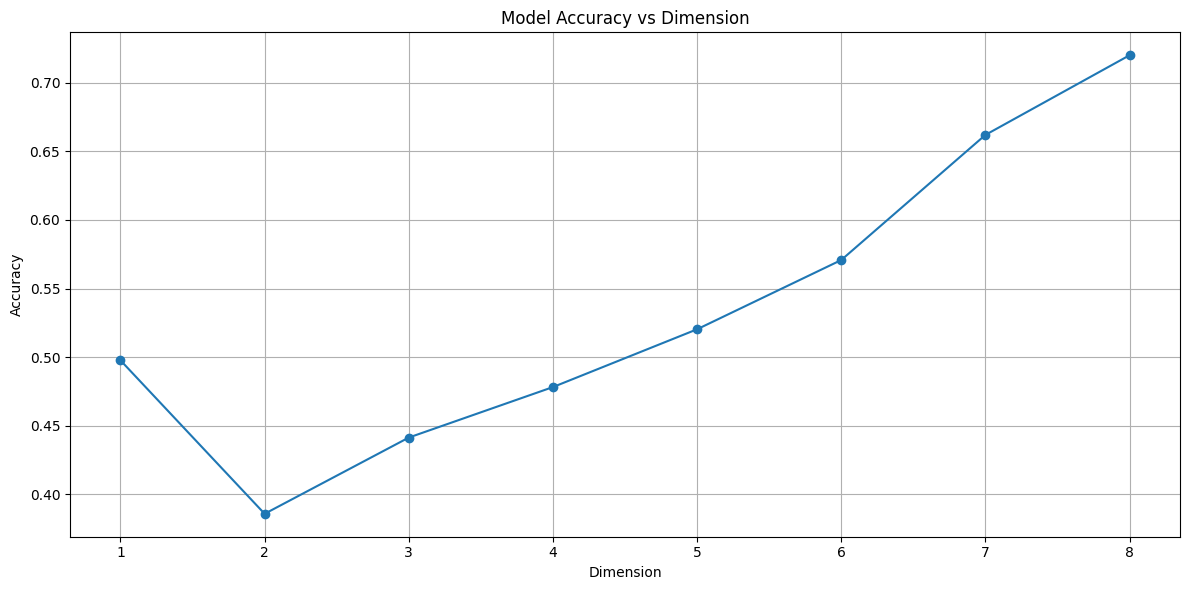

Accuracies for each dimension:
Dimension 1: Accuracy = 0.4977
Dimension 2: Accuracy = 0.3858
Dimension 3: Accuracy = 0.4414
Dimension 4: Accuracy = 0.4782
Dimension 5: Accuracy = 0.5203
Dimension 6: Accuracy = 0.5708
Dimension 7: Accuracy = 0.6620
Dimension 8: Accuracy = 0.7200

Overall Accuracy: 0.6523

Top 20 most important features:
               feature  importance
61    ExactSearch(v,Y)    0.060382
62    ExactSearch(Y,v)    0.049777
60    ExactSearch(X,v)    0.043095
69  dcor_0.5exp(v,X)^2    0.040067
21           dcor(v,X)    0.038792
..                 ...         ...
17  spearman_corr(X,Y)    0.004567
7            corr(X,Y)    0.004495
20   kendall_corr(X,Y)    0.004284
63    ExactSearch(X,Y)    0.001114
58             PC(X,Y)    0.000831

[79 rows x 2 columns]

Model and feature importances have been saved.


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


X = X_train
y = y_train
# Assuming X and y are your features and target variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=13,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42
)
# Fit the model
model.fit(X_train, y_train)

# Get predictions
y_pred = model.predict(X_test)


# Calculate accuracy for each dimension
dimensions = sorted(X_test['dimension'].unique())
accuracies = []

for dim in dimensions:
    mask = X_test['dimension'] == dim
    y_true_dim = y_test[mask]
    y_pred_dim = y_pred[mask]
    acc = accuracy_score(y_true_dim, y_pred_dim)
    accuracies.append(acc)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(dimensions, accuracies, marker='o')
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Dimension')
plt.grid(True)
plt.xticks(dimensions)  # Ensure all dimensions are shown on x-axis
plt.tight_layout()
plt.show()

# Print accuracies
print("Accuracies for each dimension:")
for dim, acc in zip(dimensions, accuracies):
    print(f"Dimension {dim}: Accuracy = {acc:.4f}")

# Calculate and print overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# Get feature importances
importances = model.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Display top 20 most important features
print("\nTop 20 most important features:")
print(feature_importances)


print("\nModel and feature importances have been saved.")

In [20]:
feature_importances

,feature,importance
61,"ExactSearch(v,Y)",0.060382
62,"ExactSearch(Y,v)",0.049777
60,"ExactSearch(X,v)",0.043095
69,"dcor_0.5exp(v,X)^2",0.040067
21,"dcor(v,X)",0.038792
...,...,...
17,"spearman_corr(X,Y)",0.004567
7,"corr(X,Y)",0.004495
20,"kendall_corr(X,Y)",0.004284
63,"ExactSearch(X,Y)",0.001114
